<a href="https://colab.research.google.com/github/JuanSpecht/PDI2021/blob/main/TP8/PDI_TP8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#PDI - Trabajo Práctico 8

## Importo las bibliotecas necesarias

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO
import ipywidgets as widgets
import IPython.display as ipd
from google.colab import files

## BACKEND

In [6]:
def downsampling (input_img, method):
    v_len_output = int(np.floor(np.shape(input_img)[0]/2))
    h_len_output = int(np.floor(np.shape(input_img)[1]/2))
    output_img = np.empty((v_len_output, h_len_output))

    bicubic_vec = np.array([-1/8, 5/8, 5/8, -1/8])
    bicubic_arr = np.outer(bicubic_vec, bicubic_vec)

    if method == 'Constante':
        for i in range(np.shape(output_img)[0]):
            for j in range(np.shape(output_img)[1]):
                output_img[i,j] = input_img[2*i, 2*j]

    elif method == 'Bilineal':
        for i in range(np.shape(output_img)[0]):
            for j in range(np.shape(output_img)[1]):
                output_img[i,j] = np.mean(input_img[2*i:2*i+2, 2*j:2*j+2])
                
    elif method == 'Bicúbico':
        input_img_padded = np.pad(input_img, 1, mode='edge')
        for i in range(np.shape(output_img)[0]):
            for j in range(np.shape(output_img)[1]):
                output_img[i, j] = np.multiply(bicubic_arr, input_img_padded[2*i:2*i+4,2*j:2*j+4]).sum()
    return output_img

def upsampling (input_img, method):
    output_img = np.empty((np.shape(input_img)[0]*2, np.shape(input_img)[1]*2))

    bicubic_vec = np.array([[-1/8, 5/8, 5/8, -1/8]])
    bicubic_arr = np.outer(bicubic_vec, bicubic_vec)

    if method == 'Constante':
        for i in range(np.shape(input_img)[0]):
            for j in range(np.shape(input_img)[1]):
                output_img[2*i:2*i+2,2*j:2*j+2] = input_img[i, j]

    elif method == 'Bilineal':
        input_img = np.append(input_img, np.array([input_img[-1,:]]), axis=0)
        input_img = np.append(input_img, np.array([input_img[:,-1]]).T, axis=1)
        for i in range(np.shape(input_img)[0]-1):
            for j in range(np.shape(input_img)[1]-1):
                output_img[2*i, 2*j] = input_img[i,j]
                output_img[2*i, 2*j+1] = np.mean([input_img[i,j], input_img[i,j+1]])
                output_img[2*i+1, 2*j] = np.mean([input_img[i,j], input_img[i+1,j]])
                output_img[2*i+1, 2*j+1] = np.mean(input_img[i:i+2,j:j+2])

    elif method == 'Bicúbico':
        input_img_padded = np.pad(input_img, 1, mode='edge')
        input_img_padded = np.append(input_img_padded, np.array([input_img_padded[-1,:]]), axis=0)
        input_img_padded = np.append(input_img_padded, np.array([input_img_padded[:,-1]]).T, axis=1)
        for i in range(np.shape(input_img)[0]):
            for j in range(np.shape(input_img)[1]):
                output_img[2*i, 2*j] = input_img[i,j]
                output_img[2*i, 2*j+1] = np.dot(bicubic_vec, np.array([input_img_padded[i+1,j:j+4]]).T)
                output_img[2*i+1, 2*j] = np.dot(bicubic_vec, np.array([input_img_padded[i:i+4,j+1]]).T)
                output_img[2*i+1, 2*j+1] = np.multiply(bicubic_arr, input_img_padded[i:i+4,j:j+4]).sum()

    return output_img

def greyscale_quantization (input_img, method, grey_levels):
    output_img = np.empty_like(input_img)
    levels_list = np.round(np.linspace(0, 255, num=grey_levels)).astype(int)

    if method == 'Uniforme':
        for i in range(np.shape(output_img)[0]):
            View.progress_bar.value = i/np.shape(output_img)[0]
            View.progress_bar.description = str(int(100 * i/np.shape(output_img)[0])) + ' %'
            for j in range(np.shape(output_img)[1]):
                idx = (np.abs(levels_list - input_img[i,j])).argmin()
                output_img[i,j] = np.clip(levels_list[idx], 0, 255)                

    elif method == 'Dithering aleatorio':
        for i in range(np.shape(output_img)[0]):
            View.progress_bar.value = i/np.shape(output_img)[0]
            View.progress_bar.description = str(int(100 * i/np.shape(output_img)[0])) + ' %'
            for j in range(np.shape(output_img)[1]):
                probs = np.clip(1 - np.abs(levels_list - input_img[i,j])/255, 0, 1)
                '''Abajo obligo a cada pixel a elegir entre el valor 
                inmediatamente anterior o el siguiente de la lista de niveles 
                de gris, pero ningún otro'''
                probs[probs < 1-(1/(grey_levels-1))] = 0
                probs = probs / np.sum(probs)
                output_img[i,j] = np.random.choice(levels_list,
                                                 p=probs)
                output_img[i,j] = np.clip(output_img[i,j], 0, 255)

    elif method == 'Difusión del error':
        for i in range(np.shape(output_img)[0]):
            try:
                View.progress_bar.value = i/np.shape(output_img)[0]
                View.progress_bar.description = str(int(100 * i/np.shape(output_img)[0])) + ' %'
            except:
                pass
            error = 0
            for j in range(np.shape(output_img)[1]):
                idx = (np.abs(levels_list - (input_img[i,j]-error))).argmin()
                output_img[i,j] = np.clip(levels_list[idx], 0, 255) 
                error = error + output_img[i,j] - input_img[i,j]

    return output_img

def apply_operation (input_img, operation, method, grey_levels=None):
    if operation == "Downsampling X2":
        output_img = downsampling(input_img, method)

    elif operation == "Upsampling X2":
        output_img = upsampling(input_img, method)

    elif operation == "Cuantización del nivel de gris":
        output_img = greyscale_quantization(input_img, method, grey_levels)
    
    return output_img

## FRONTEND

In [3]:
class TP8_UI:

    def __init__(self):
        # Creo la caja donde van los controles
        self.controls_box = widgets.VBox(layout=widgets.Layout(
            align_items='center',))

        self.par = dict()
        self.par['options'] = dict()

        self.initUI()

    def initUI(self):
        # Inicializo las funciones que manejan los widgets
        self.initMethodDropdown()
        self.initGreyLevelsSlider()
        self.initOperationDropdown()
        self.initLoadButton()
        self.initSaveButton() 
        self.initRunButton()
        self.initResetButton()
        self.initProgressBar()

        # Armo el layout de la interfaz
        self.controls = widgets.VBox([
            widgets.GridBox([self.load_button,
                             self.run_button,
                             self.save_button,
                             self.reset_button],
                            layout=widgets.Layout(grid_template_columns="1fr 1fr",
                                                  grid_template_rows="1fr 1fr")),
            self.controls_box
            ],
            layout=widgets.Layout(align_items='stretch'))

        self.input_image = widgets.Output(layout=widgets.Layout(
            overflow_x='hidden',
            overflow_y='hidden',
            justify_content='center',
            align_items='center'))

        self.output_image = widgets.Output(layout=widgets.Layout(
            overflow_x='hidden',
            overflow_y='hidden',
            justify_content='center',
            align_items='center'))

        self.image_panel = widgets.VBox([widgets.HBox([self.input_image,
                                                       self.output_image]),
                                         self.progress_bar]
                                        )
        
        self.UI = widgets.HBox([self.controls,self.image_panel])

    def initLoadButton(self):
        self.load_button = widgets.FileUpload(
            accept='',
            multiple=False,
            description="Abrir"
            )
        
        self.load_button.observe(self.updateInputImage, 'value')
    
    def updateInputImage(self, change):
        self.par['input_image'] = np.array(Image.open(BytesIO(self.load_button.data[0])).convert('L'))
        
        with self.input_image:
            ipd.clear_output()
            fig, ax = plt.subplots(figsize=(7,7))
            plt.imshow(self.par['input_image'], cmap='gray', interpolation="nearest")
            plt.Axes(fig, [0,0,1,1])
            plt.axis('off')
            plt.show()

    def initRunButton(self):
        self.run_button = widgets.Button(description="Aplicar")
        self.run_button.on_click(self.updateOutputImage)
    
    def updateOutputImage(self, change):
        with self.output_image:
            ipd.clear_output()
            
        self.progress_bar.layout.visibility = 'visible'

        img = self.par['input_image']
        operation = self.par['operation']  
        grey_levels = self.par['grey levels']

        self.par['output_image'] = apply_operation(
            img,
            operation,
            self.par['method'],
            grey_levels = grey_levels
            )
        
        with self.output_image:
            fig, ax = plt.subplots(figsize=(7,7))
            plt.imshow(self.par['output_image'], 'gray', interpolation="nearest")
            plt.Axes(fig, [0,0,1,1])
            plt.axis('off')
            plt.show()
        
        self.progress_bar.layout.visibility = 'hidden'

    def initOperationDropdown(self):
        self.operation_dropdown = widgets.Dropdown(
            options=["Downsampling X2",
                     "Upsampling X2",
                     "Cuantización del nivel de gris"],
                     description='Operación:', 
                    layout=widgets.Layout(width='max_content',),
                     continuous_update=True)
        
        self.updateOperation(None)

        self.operation_dropdown.observe(self.updateOperation, "value")

    def updateOperation(self, change):
        self.par['operation'] = self.operation_dropdown.value

        if self.par['operation'] == "Downsampling X2" or \
        self.par['operation'] == "Upsampling X2":
            self.controls_box.children = [self.operation_dropdown,
                                          self.method_dropdown]
            self.method_dropdown.options = ['Constante',
                                            'Bilineal',
                                            'Bicúbico']

        elif self.par['operation'] == "Cuantización del nivel de gris":
            self.controls_box.children = [self.operation_dropdown,
                                          self.method_dropdown,
                                          self.grey_levels_slider]
            self.method_dropdown.options = ['Uniforme',
                                            'Dithering aleatorio',
                                            'Difusión del error']
            

    def initMethodDropdown(self):
        self.method_dropdown = widgets.Dropdown(
                                                options=['Constante',
                                                         'Bilineal',
                                                         'Bicúbico'],
                                                description='Método:',
                                                disabled=False
                                            )
        
        self.updateMethod(None)

        self.method_dropdown.observe(self.updateMethod, "value")

    def updateMethod(self, change):
        self.par['method'] = self.method_dropdown.value        

    def initGreyLevelsSlider(self):
        self.grey_levels_slider = widgets.IntSlider(
                                                value=2,
                                                min=2,
                                                max=10,
                                                step=1,
                                                description='Niveles de gris:',
                                                disabled=False,
                                                continuous_update=True,
                                                orientation='horizontal',
                                                readout=True,
                                                readout_format='d',
                                                )
        
        self.updateGreyLevels(None)

        self.grey_levels_slider.observe(self.updateGreyLevels, "value")

    def updateGreyLevels(self, change):
        self.par['grey levels'] = self.grey_levels_slider.value

    def initSaveButton(self):
        self.save_button = widgets.Button(description="Guardar")
        self.save_button.on_click(self.saveImage)

    def saveImage(self,change):
        img_to_save = Image.fromarray(np.uint8(self.par["output_image"]))
        output_filename = self.par['filter'] + '.jpg'
        img_to_save.save(output_filename)
        print('La imagen ha sido guardada como ' + '\'' + output_filename + '\'.')
    
    def initResetButton(self):
        self.reset_button = widgets.Button(description='Reiniciar imagen')
        self.reset_button.on_click(self.updateInputImage)

    def initProgressBar(self):
        self.progress_bar = widgets.FloatProgress(
            value=0,
            min=0,
            max=1,
            bar_style='info',
            style={'bar_color': 'green'},
            orientation='horizontal',
            layout=widgets.Layout(width='max_content',
                                  visibility = 'hidden')
        )
        
    def _ipython_display_(self):
        display(self.UI)

View = TP8_UI()
View

## Comparación de los diferentes filtros

Saving img_TP8.jpg to img_TP8.jpg


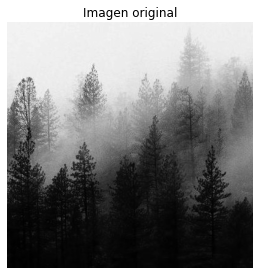

In [5]:
# Cargo y grafico la imagen original
uploaded = files.upload()
keys_list = list(uploaded)
key = keys_list[0]
img = np.array(Image.open(BytesIO(uploaded[key])).convert('L'))
fig, ax = plt.subplots()
fig.tight_layout()
ax.title.set_text('Imagen original')
ax.imshow(img, cmap='gray')
ax.axis('off')
plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.show()

## Downsampling y upsampling 

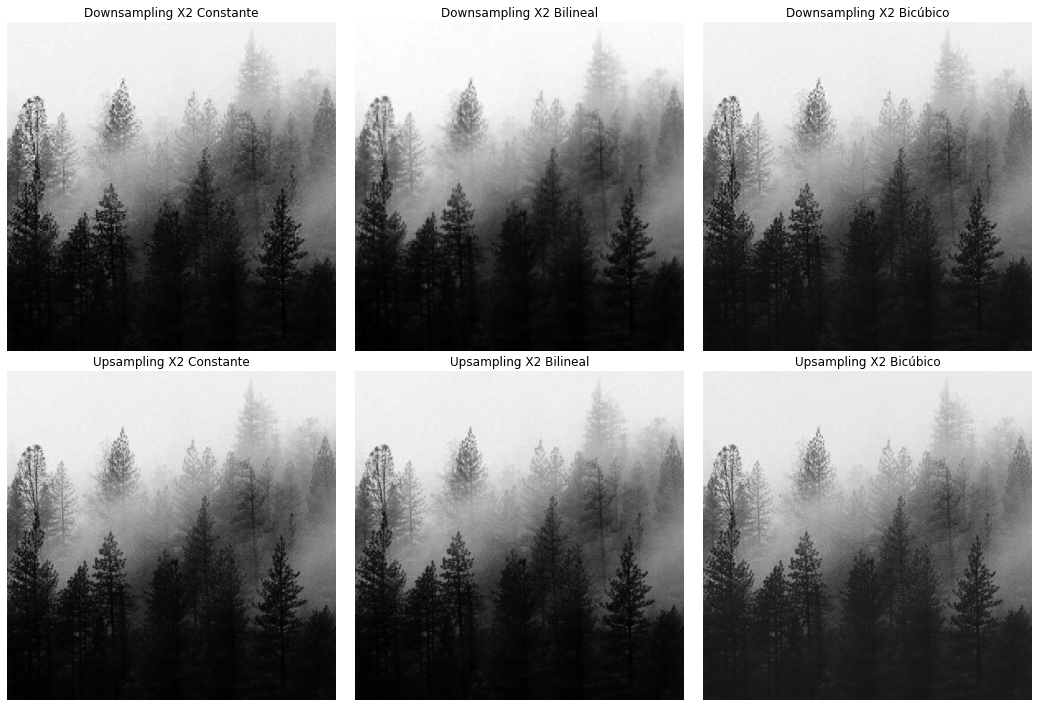

In [26]:
input = img

operations = ['Downsampling X2', 'Upsampling X2']
methods = ['Constante', 'Bilineal', 'Bicúbico']

fig, axs = plt.subplots(2,3,figsize=(15,10))
fig.tight_layout()
for i in range(2):
    operation = operations[i]
    for j in range(3):
        method = methods[j]
        output = apply_operation(input, operation, method)
        axs[i,j].title.set_text(operation + ' ' + method)
        axs[i,j].imshow(output, 'gray')
        axs[i,j].axis('off')

plt.subplots_adjust(wspace=0.05, hspace=0.06)
plt.show()

* Al hacer downsampling con una función constante aparecen pequeños artificios (algunos píxeles muy claros aislados en zonas oscuras), que no se producen al utilizar una función bilineal o bicúbica.

## Cuantización del nivel de gris

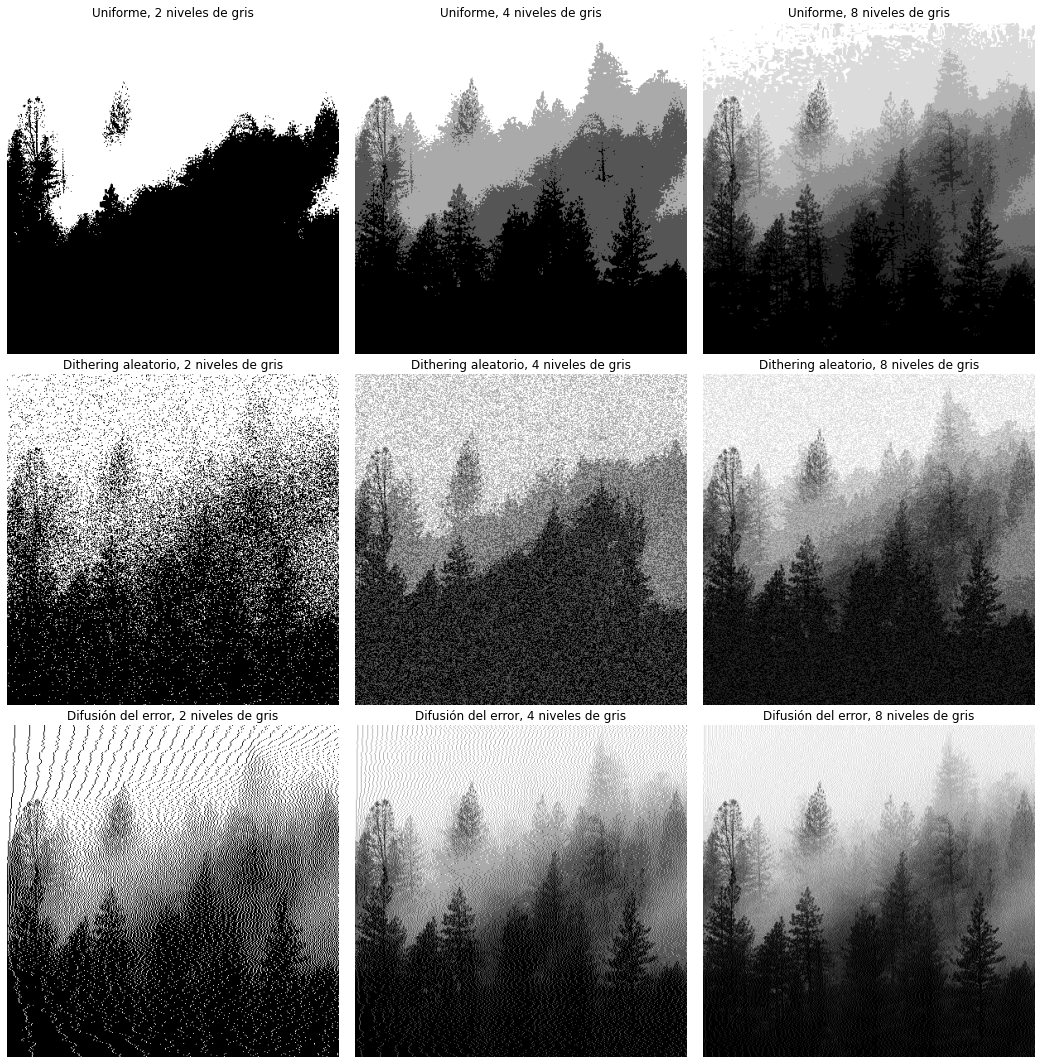

In [33]:
input = img

operation = 'Cuantización del nivel de gris'
methods = ['Uniforme','Dithering aleatorio','Difusión del error']
grey_levels_list = [2,4,8]

fig, axs = plt.subplots(3,3,figsize=(15,15))
fig.tight_layout()
for i in range(3):
    method = methods[i]
    for j in range(3):
        grey_levels = grey_levels_list[j]
        output = apply_operation(input, operation, method, grey_levels=grey_levels)
        axs[i,j].title.set_text(method + ', ' + str(grey_levels) + ' niveles de gris')
        axs[i,j].imshow(output, 'gray')
        axs[i,j].axis('off')

plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.show()

* Al utilizar una cuantización uniforme aparecen pixeles completamnte blancos y completamente negros. Dichos valores están fuera del rango de luminancias de la imagen original. Esto se solucionaría sencillamente acotando los extremos en los niveles de gris a los valores extremos de la imagen original.
* Se nota el ruido que aparece con el dithering aleatorio y las líneas que aparecen al utilizar difusión del error. Al aumentar la cantidad de niveles de gris ambos efectos se reducen, al mismo tiempo que la imagen reproduce mejor a la original.
